In [1]:
##import blabla

import keras 
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, Flatten, Reshape, ZeroPadding2D, Conv2D, MaxPooling2D,ConvLSTM2D,BatchNormalization, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.utils.data_utils import get_file
from keras.optimizers import Adam


import os
import numpy as np
import scipy
import scipy.misc
import matplotlib.pyplot as pl



/Users/nicholasgoh/Documents/4YP/TF/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/nicholasgoh/Documents/4YP/TF/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# print every npz in directory
in_dir = './output'
lmks =[]
images = []
seriesnumbers = []
imageposition = []
dirs = ['{}/{}'.format(in_dir,d) for d in os.listdir(in_dir) if d.endswith('.npz')]
for dir in dirs:
    woop = np.load(dir)
    lmks.append(woop['lmks'])
    images.append(woop['images'])
    seriesnumbers.append(woop['SeriesNumber'])
    imageposition.append(woop['ImagePosition'])
                
lmks = np.array(lmks)
images = np.array(images)
seriesnumbers =np.array(seriesnumbers)
imageposition = np.array(imageposition)

totalsequences = 0
for i in range(len(lmks)):
    if np.shape(images[i])[0]<6:
        totalsequences+=1
    else:
        totalsequences+= np.shape(images[i])[0]-4


sampledlmks = np.zeros((totalsequences,5,6,1))
sampledimages = np.zeros((totalsequences,5,224,224,3))
reversedlmks = np.zeros((totalsequences,5,6,1))
reversedimages = np.zeros((totalsequences,5,224,224,3))
k=0
for i in range(len(lmks)):
#     sortpos= np.argsort(seriesnumbers[i])
    if np.shape(images[i])[0]<6:
        sortpos = np.argsort(imageposition[i][:,2])
        lmks[i] = lmks[i][sortpos]
        images[i]=images[i][sortpos]
        sampledlmks[k][:len(lmks[i])] = lmks[i][:]
        sampledimages[k][:len(lmks[i])]=images[i][:]
        k+=1

    else:
        sortpos = np.argsort(imageposition[i][:,2])
        lmks[i] = lmks[i][sortpos]
        images[i] = images[i][sortpos]
        for j in range(np.shape(images[i])[0]-4): 
            sampledlmks[k] = lmks[i][j:5+j]
            sampledimages[k] = images[i][j:5+j]
            k+=1

for i in range(len(sampledimages)):
    reversedimages[i]=sampledimages[i][::-1]
    reversedlmks[i] = sampledlmks[i][::-1]
    
sampledimages = np.concatenate([sampledimages,reversedimages])
sampledlmks = np.concatenate([sampledlmks,reversedlmks])     
print(sampledlmks.shape)
    

In [4]:
##data augmentation portion - First do Train - Valid - Test Splin
import random
index = random.sample(range(sampledimages.shape[0]),sampledimages.shape[0])
index = np.array(index)

# index = np.load('/inputs/indexes.npy')
# augmented_x=np.load('/inputs/augmentedx.npy')
# augmented_y=np.load('/inputs/augmentedy.npy')

sampledimages = sampledimages[index]
sampledlmks = sampledlmks[index]
trainingsize  = int(np.round(1366*0.7))
xtrain,xvalid,xtest = sampledimages[:trainingsize],sampledimages[trainingsize:trainingsize+204],sampledimages[trainingsize+204:]
ytrain,yvalid,ytest = sampledlmks[:trainingsize],sampledlmks[trainingsize:trainingsize+204],sampledlmks[trainingsize+204:]
ytrain = ytrain.reshape(len(ytrain),5,6)
yvalid =yvalid.reshape(len(yvalid),5,6)
ytest = ytest.reshape(len(ytest),5,6,)
del sampledimages, sampledlmks

xtrain_original = xtrain
ytrain_original = ytrain

xtrain = np.rollaxis(xtrain,1,-1)
print(xtrain.shape)
xtrain = xtrain[:,:,:,:,0]
print(xtrain.shape)



# augmentedx=np.zeros([augmented_x.shape[0],5,224,224,3])
# x_valid= np.zeros([xvalid.shape[0],5,224,224,3])
# x_test= np.zeros([xtest.shape[0],5,224,224,3])

# xtrain.shape
# augmentedx[:,:,:,:,0]= augmented_x[:,:,:,:]
# augmentedx[:,:,:,:,1]= augmented_x[:,:,:,:]
# augmentedx[:,:,:,:,2]= augmented_x[:,:,:,:]

# xvalid[:,:,:,:,0]= xvalid[:,:,:,:,0]
# xvalid[:,:,:,:,1]= xvalid[:,:,:,:,0]
# xvalid[:,:,:,:,2]= xvalid[:,:,:,:,0]

# xtest[:,:,:,:,0]= xtest[:,:,:,:,0]
# xtest[:,:,:,:,1]= xtest[:,:,:,:,0]
# xtest[:,:,:,:,2]= xtest[:,:,:,:,0]




(956, 224, 224, 5, 3)
(956, 224, 224, 5)


'/Users/nicholasgoh/Desktop/Matlab_4YP/Floyd/LRCN'

In [ ]:
def VGG16_LSTM():
    WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    patch_rows = 224
    patch_cols = 224

    inputs = Input((5, patch_rows, patch_cols, 3))

    conv1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),name='block1_conv1')(inputs)
#     conv1 = TimeDistributed(BatchNormalization())(conv1)
    conv1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),name='block1_conv2')(conv1)
#     conv1 = TimeDistributed(BatchNormalization())(conv1)
    pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)),name='block1_pool')(conv1)

    conv2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'),name='block2_conv1')(pool1)
#     conv2 = TimeDistributed(BatchNormalization())(conv2)
    conv2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'),name='block2_conv2')(conv2)
#     conv2 = TimeDistributed(BatchNormalization())(conv2)
    pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)),name='block2_pool')(conv2)

    conv3 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'),name='block3_conv1')(pool2)
#     conv3 = TimeDistributed(BatchNormalization())(conv3)
    conv3 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'),name='block3_conv2')(conv3)
#     conv3 = TimeDistributed(BatchNormalization())(conv3)
    pool3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2),name='block3_pool'))(conv3)

    conv4 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'),name='block4_conv1')(pool3)
#     conv4 = TimeDistributed(BatchNormalization())(conv4)
    conv4 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'),name='block4_conv2')(conv4)
#     conv4 = TimeDistributed(BatchNormalization())(conv4)
    pool4 = TimeDistributed(MaxPooling2D(pool_size=(2, 2),name='block4_pool'))(conv4)


    conv5 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'),name='block5_conv1')(pool4)
#     conv5 = TimeDistributed(BatchNormalization())(conv5)
    conv5 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'),name='block5_conv2')(conv5)
#     conv5 = TimeDistributed(BatchNormalization())(conv5)
    pool5 = TimeDistributed(MaxPooling2D(pool_size=(2, 2),name='block5_pool'))(conv5)

    myLSTM = ConvLSTM2D(512, (3, 3), activation='relu', padding='same', return_sequences=True,name='ConvLSTMlayer1')(pool5)
    myLSTM = ConvLSTM2D(512, (3, 3), activation='relu', padding='same', return_sequences=True,name='ConvLSTMlayer2')(myLSTM)
    myLSTM = ConvLSTM2D(512, (3, 3), activation='relu', padding='same', return_sequences=True,name='ConvLSTMlayer3')(myLSTM )
    
    
    flatten = TimeDistributed(Flatten())(myLSTM)
#     fc1 = Dense(4096, name ='fc1')(flatten)
#     fc2 = Dense(4096, name = 'fc2')(fc1)
    reg_out = TimeDistributed(Dense(6, name='predictions'))(flatten)
    
    VGG16_path_NOTOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
    model = Model(inputs=[inputs], outputs=[reg_out])
    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',WEIGHTS_PATH, cache_subdir='models')
    model.load_weights(weights_path,by_name=True,)

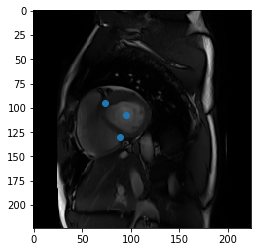

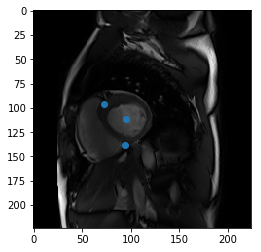

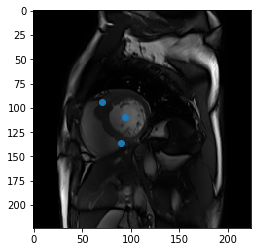

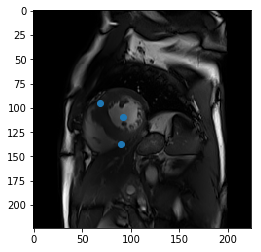

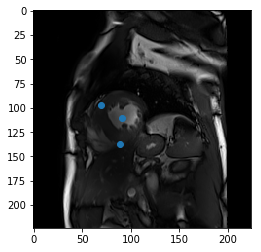

epoch  0


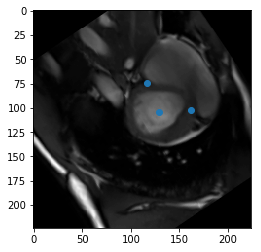

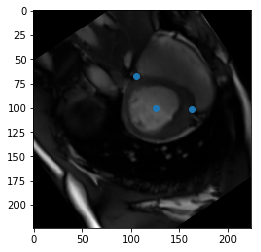

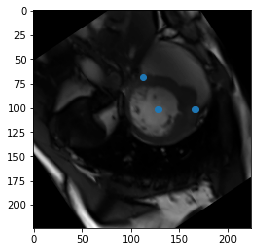

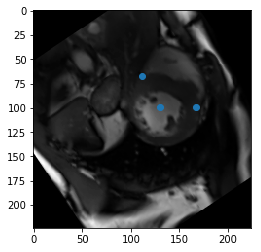

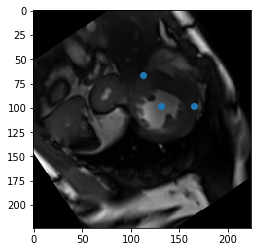

epoch  1


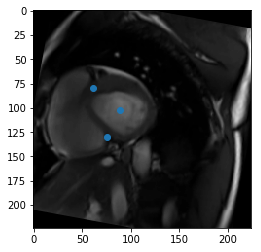

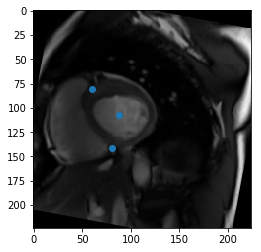

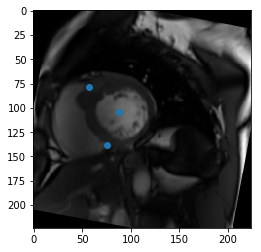

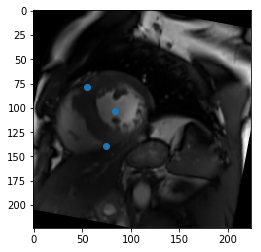

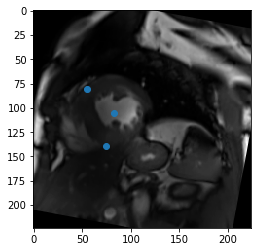

epoch  2


In [22]:
# image augmentation - Do it after testing the network
import cv2
import imgaug as ia
from imgaug import augmenters as iaa #imgaug is not a default package on FLOYD


seq = iaa.Sequential([
    iaa.Crop(px=(0, 32)), # crop images from each side by 0 to 32px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Flipud(0.5),
    iaa.Affine(scale={"x": (0.7, 1.3), "y": (0.7, 1.3)}), # zoom in/zoom out
    iaa.Affine(rotate=(-45, 45))# rotate by -45 to +45 degrees
    ]) 

# model = VGG16_LSTM()
# # model.compile(loss= "mse", optimizer=Adam(lr=0.001))
# #model.load_weights('/model/weights-best)
# filepath= "/output/weights-best"
# # checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# # callbacks_list = [checkpoint]
# model.summary()

epochnumber = 3
for epoch in range(epochnumber):
##define sequntial transformation - check this
    if epoch == 0:
        augmented_x= xtrain_original
        augmentedy= ytrain_original
        augmentedy = np.reshape(augmentedy, (xtrain.shape[0],5,6))
        augmented_x = np.reshape(augmented_x, (xtrain.shape[0],224,224,5))
        augmented_x = np.rollaxis(augmented_x,-1,1)
        augmented_x= augmented_x[:,:,:,:,np.newaxis]

        
        augmentedx=np.zeros([augmented_x.shape[0],5,224,224,3])
        augmentedx[:,:,:,:,0]= augmented_x[:,:,:,:,0]
        augmentedx[:,:,:,:,1]= augmented_x[:,:,:,:,0]
        augmentedx[:,:,:,:,2]= augmented_x[:,:,:,:,0]
        plotsequence(50)
        print("epoch ", epoch)
        
#       history = model.fit(augmentedx, augmentedy, callbacks=callbacks_list, batch_size=1, epochs=1, verbose=1, validation_data=(xvalid,yvalid))
    else:   
        augmented_x,augmented_y, = [],[]
        seq_det = seq.to_deterministic()
        images_aug = []
        keypoints_aug=[]
        keypoints_on_images = [] # reinitiliase landmarks on each image

        for k in range(xtrain.shape[0]):  ##iterate over each image sequence in xtrain
            keypoints = []
            for l in range(5): 
                for i in range(3):
                    y = ytrain[k,l,0+(2*i)]
                    x = ytrain[k,l,1+(2*i)]
                    keypoints.append(ia.Keypoint(x=x, y=y))
            keypoints_on_images.append(ia.KeypointsOnImage(keypoints, shape=(224,224,5)))

        imaug = seq_det.augment_images(xtrain)
        keyptsaug = seq_det.augment_keypoints(keypoints_on_images)
        keypoints_on_images = []
        images_aug.append(imaug)
        keypoints_aug.append(keyptsaug)
        del imaug, keyptsaug

        for k in range(xtrain.shape[0]):
            for l in range(3*5):
                    augmented_y.append(keypoints_aug[0][k].keypoints[l].y)
                    augmented_y.append(keypoints_aug[0][k].keypoints[l].x)
            augmented_x.append(images_aug[0][k])

        augmented_y = np.array(augmented_y)
        augmentedy = np.reshape(augmented_y, (xtrain.shape[0],5,6))

        augmented_x = np.array(augmented_x)
        augmented_x = np.reshape(augmented_x, (xtrain.shape[0],224,224,5))
        augmented_x = np.rollaxis(augmented_x,-1,1)
        augmented_x = augmented_x[:,:,:,:,np.newaxis]

        augmentedx=np.zeros([augmented_x.shape[0],5,224,224,3])
        augmentedx[:,:,:,:,0]= augmented_x[:,:,:,:,0]
        augmentedx[:,:,:,:,1]= augmented_x[:,:,:,:,0]
        augmentedx[:,:,:,:,2]= augmented_x[:,:,:,:,0]

        plotsequence(50)
        print("epoch ", epoch)


# augmentedx = np.concatenate([xtrain_original,augmentedx])
# augmentedx = np.rollaxis(augmentedx,-1,1)
# augmentedy = np.concatenate([ytrain_original,augmentedy])

# np.save('augmentedx',augmentedx)
# np.save('augmentedy',augmentedy)

In [20]:
augmented_x[:,:,:,:,0]

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
    

In [6]:
def plotsequence(seqno):

    import matplotlib.pyplot as plt

    for index in range(5):


        ypoints = (augmentedy[seqno][index][0],augmentedy[seqno][index][2],augmentedy[seqno][index][4])
        xpoints = (augmentedy[seqno][index][1],augmentedy[seqno][index][3],augmentedy[seqno][index][5])
        # ypredict = (yhaha[index,0],yhaha[index,2],yhaha[index,4])
        # xpredict = (yhaha[index,1],yhaha[index,3],yhaha[index,5])

        plt.imshow(augmentedx[seqno][index][:,:,0],'gray')
        plt.scatter(xpoints,ypoints,cmap='r')
        # plt.scatter(xpredict,ypredict,cmap='b')
        plt.show()
        plt.clf()

In [74]:
for k in range(xtrain.shape[0]):
    for l in range(3*5):
            augmentedy.append(keypoints_aug[0][k].keypoints[l].y)
            augmentedy.append(keypoints_aug[0][k].keypoints[l].x)
    augmentedx.append(images_aug[0][k])
            
augmentedy = np.array(augmentedy)
augmentedy = np.reshape(augmentedy, (xtrain.shape[0],5,6))
augmentedx = np.array(augmentedx)
augmentedx = np.reshape(augmentedx, (xtrain.shape[0],224,224,5))
augmentedx = np.rollaxis(augmentedx,-1,1)




# images_aug[0][1][160]
#                 localy[k,l,0]=keypoints_aug[l].keypoints[0].y
#                 localy[k,l,1]=keypoints_aug[l].keypoints[0].x
#                 localy[k,l,2]=keypoints_aug[l].keypoints[1].y
#                 localy[k,l,3]=keypoints_aug[l].keypoints[1].x
#                 localy[k,l,4]=keypoints_aug[l].keypoints[2].y
#                 localy[k,l,5]=keypoints_aug[l].keypoints[2].x


#         augmentedy[(p)*xtrain.shape[0]+k,:,:,:]=localy[k,:,:,:]
#         augmentedx[(p)*xtrain.shape[0]+k,:,:,:,:]=images_aug[:,:,:,:]
        
#     del localy
#     del images_aug
        
# augmentedx=np.concatenate([xtrain,augmentedx])
# augmentedy=np.concatenate([ytrain,augmentedy])       
        
        
    

            

In [75]:
augmentedx.shape

(956, 5, 224, 224)

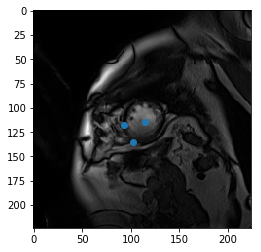

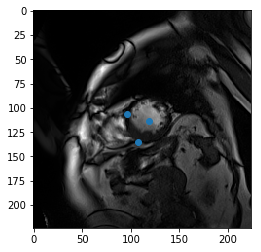

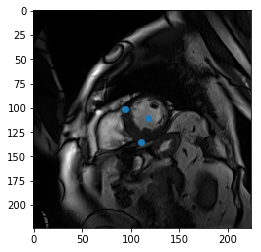

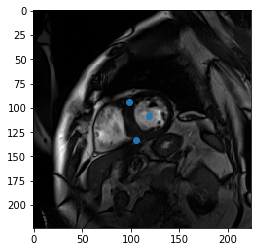

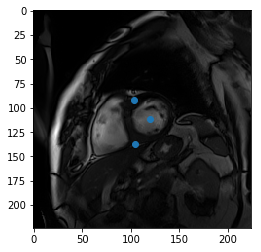

In [8]:
import matplotlib.pyplot as plt
seqno=8

for index in range(5):


    ypoints = (ytrain[seqno][index][0],ytrain[seqno][index][2],ytrain[seqno][index][4])
    xpoints = (ytrain[seqno][index][1],ytrain[seqno][index][3],ytrain[seqno][index][5])
    # ypredict = (yhaha[index,0],yhaha[index,2],yhaha[index,4])
    # xpredict = (yhaha[index,1],yhaha[index,3],yhaha[index,5])

    plt.imshow(xtrain[seqno][index][:,:,0],'gray')
    plt.scatter(xpoints,ypoints,cmap='r')
    # plt.scatter(xpredict,ypredict,cmap='b')
    plt.show()
    plt.clf()

In [51]:
def VGG16_LSTM():
    WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    patch_rows = 224
    patch_cols = 224

    inputs = Input((5, patch_rows, patch_cols, 3))

    conv1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),name='block1_conv1')(inputs)
#     conv1 = TimeDistributed(BatchNormalization())(conv1)
    conv1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),name='block1_conv2')(conv1)
#     conv1 = TimeDistributed(BatchNormalization())(conv1)
    pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)),name='block1_pool')(conv1)

    conv2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'),name='block2_conv1')(pool1)
#     conv2 = TimeDistributed(BatchNormalization())(conv2)
    conv2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'),name='block2_conv2')(conv2)
#     conv2 = TimeDistributed(BatchNormalization())(conv2)
    pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)),name='block2_pool')(conv2)

    conv3 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'),name='block3_conv1')(pool2)
#     conv3 = TimeDistributed(BatchNormalization())(conv3)
    conv3 = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'),name='block3_conv2')(conv3)
#     conv3 = TimeDistributed(BatchNormalization())(conv3)
    pool3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2),name='block3_pool'))(conv3)

    conv4 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'),name='block4_conv1')(pool3)
#     conv4 = TimeDistributed(BatchNormalization())(conv4)
    conv4 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'),name='block4_conv2')(conv4)
#     conv4 = TimeDistributed(BatchNormalization())(conv4)
    pool4 = TimeDistributed(MaxPooling2D(pool_size=(2, 2),name='block4_pool'))(conv4)


    conv5 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'),name='block5_conv1')(pool4)
#     conv5 = TimeDistributed(BatchNormalization())(conv5)
    conv5 = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'),name='block5_conv2')(conv5)
#     conv5 = TimeDistributed(BatchNormalization())(conv5)
    pool5 = TimeDistributed(MaxPooling2D(pool_size=(2, 2),name='block5_pool'))(conv5)

    myLSTM = ConvLSTM2D(512, (3, 3), activation='relu', padding='same', return_sequences=True,name='ConvLSTMlayer')(pool5)
    
    flatten = TimeDistributed(Flatten())(myLSTM)
    fc1 = Dense(4096, name ='fc1')(flatten)
    fc2 = Dense(4096, name = 'fc2')(fc1)
    reg_out = Dense(6, name='predictions')(fc2)
    
    VGG16_path_NOTOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'

    model = Model(inputs=[inputs], outputs=[reg_out])


    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',WEIGHTS_PATH, cache_subdir='models')
    model.load_weights(weights_path,by_name=True,)

    return model




In [27]:
sampledlmks = np.zeros((0,5,6,1))
sampledimages = np.zeros((0,5,224,224,3))
for i in range(len(lmks)):
#     sortpos= np.argsort(seriesnumbers[i])
    if np.shape(images[i])[0]<5:
        sortpos = np.argsort(imageposition[i][:,2])
        sampledlmks.append(lmks[i][:])
        sampledlmks.append(np.zeros(1,1,6,1))
        sampledimages.append(images[i][sortpos])
        sampledimages.append(np.zeros(1,1,224,224,3))

AttributeError: 'numpy.ndarray' object has no attribute 'concat'

In [34]:
sampledlmks = np.zeros((0,5,6,1))
np.append(sampledlmks,np.zeros((1,1,6,1)),axis=0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [38]:
totalsequences = 0
for i in range(len(lmks)):
    if np.shape(images[i])[0]<6:
        totalsequences+=1
    else:
        totalsequences+= np.shape(images[i])[0]-4
print(totalsequences)


683


In [45]:
papa=sampledimages.reshape(5,683,224,224,3)
papa.shape

(5, 683, 224, 224, 3)

In [56]:
xtrain.shape

(478, 5, 224, 224, 3)

In [62]:
sampledlmks[1]

array([[[ 84.],
        [128.],
        [106.],
        [118.],
        [102.],
        [141.]],

       [[ 80.],
        [133.],
        [111.],
        [119.],
        [104.],
        [141.]],

       [[ 87.],
        [126.],
        [104.],
        [119.],
        [102.],
        [139.]],

       [[ 84.],
        [153.],
        [106.],
        [115.],
        [103.],
        [140.]],

       [[ 80.],
        [148.],
        [108.],
        [114.],
        [105.],
        [141.]]])

In [55]:
model = VGG16_LSTM()
model.compile(loss= "mse", optimizer=Adam(lr=0.001))

# checkpoints

filepath= "/output/weights-best"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.summary()

# #training 
history = model.fit(xtrain, ytrain, callbacks=callbacks_list, batch_size=1, epochs=5, verbose=1, validation_data=(xvalid,yvalid))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 5, 224, 224, 3)    0         
_________________________________________________________________
block1_conv1 (TimeDistribute (None, 5, 224, 224, 64)   1792      
_________________________________________________________________
time_distributed_80 (TimeDis (None, 5, 224, 224, 64)   256       
_________________________________________________________________
block1_conv2 (TimeDistribute (None, 5, 224, 224, 64)   36928     
_________________________________________________________________
time_distributed_81 (TimeDis (None, 5, 224, 224, 64)   256       
_________________________________________________________________
block1_pool (TimeDistributed (None, 5, 112, 112, 64)   0         
_________________________________________________________________
block2_conv1 (TimeDistribute (None, 5, 112, 112, 128)  73856     
__________

KeyboardInterrupt: 

In [5]:
np.save("xtrain",xtrain)
np.save("ytrain",ytrain)
np.save("xvalid",xvalid)
np.save("xtest",xtest)
np.save("yvalid",yvalid)
np.save("ytest",ytest)


In [61]:
yvalid.shape

(204, 5, 6)